# Deconvolution of the *Thickness* effect

This is the third part of this long journey in the thickness of the silicon sensor of the Pilatus detector:
after characterizing the precise position of the Pilatus-1M on the goniometer of ID28 we noticed there are some discrepancies in the ring position and peak width as function of the position on the detector. 
In a second time the thickness of the detector was modeled and allowed us to define a sparse-matrix which represent the bluring of the signal with a point-spread function which actually depends on the position of the detector.
This convolution can be revereted using techniques developped for inverse problems. 
Two pseudo-inversion algorithm have been tested, either limiting least-squares errors or with poissonian constrains. 

We will now correct the images of the first notebook called "goniometer" with the sparse matrix calculated in the second one (called "raytracing") and check if the pick-width is less chaotic and if peaks are actually thinner.

In [1]:
%matplotlib nbagg

In [2]:
import os
import time
start_time = time.time()

In [3]:
import numpy
import fabio, pyFAI
from os.path import basename
from pyFAI.gui import jupyter
from pyFAI.calibrant import get_calibrant
from silx.resources import ExternalResources
from matplotlib.pyplot import subplots
from matplotlib.lines import Line2D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
downloader = ExternalResources("thick", "http://www.silx.org/pub/pyFAI/testimages")
all_files = downloader.getdir("gonio_ID28.tar.bz2")
for afile in all_files:
    print(basename(afile))

gonio_ID28
det130_g45_0001p.npt
det130_g0_0001p.cbf
det130_g17_0001p.npt
det130_g0_0001p.npt
det130_g45_0001p.cbf
det130_g17_0001p.cbf


In [5]:
from scipy.sparse import save_npz, load_npz, csr_matrix, csc_matrix, linalg
#Saved in notebook called "raytracing"
csr = load_npz("csr.npz")

<IPython.core.display.Javascript object>


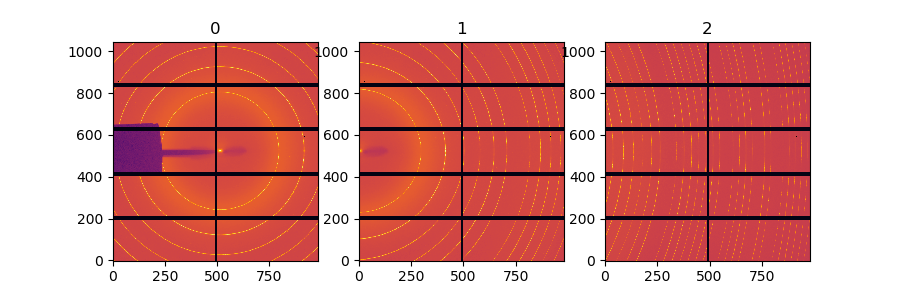

In [6]:
# Display all images as acquired
mask = numpy.load("mask.npy")
images = [fabio.open(i).data for i in sorted(all_files) if i.endswith("cbf")]

fig, ax = subplots(1, 3, figsize=(9,3))
for i, img in enumerate(images):
    jupyter.display(img, ax=ax[i], label=str(i))

<IPython.core.display.Javascript object>


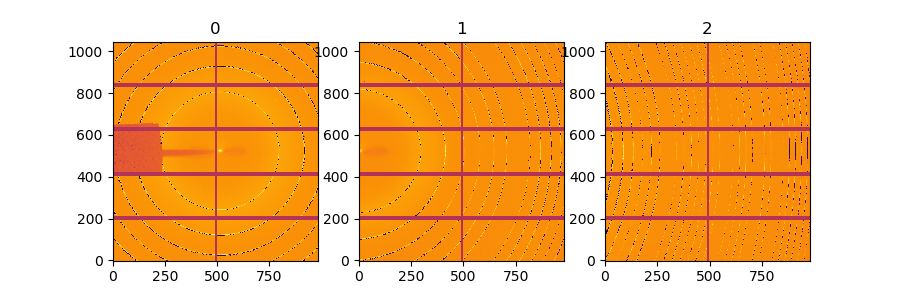

(1, 22, 67.53766751120409, 11.129642745894946, 1.8245371636630272, 3.948378116039215, 44886758.46784883)
(1, 22, 71.19252340495744, 12.081752507142443, 1.8280343579375222, 3.918061149282325, 38825906.04977599)
(1, 23, 30.369625768691204, 5.231363709428408, 1.8620379956606512, 3.905307157273793, 16554013.80570858)


In [7]:
# Display all images once they have been corrected with least-squares minimization

fig, ax = subplots(1, 3, figsize=(9,3))

msk = numpy.where(mask)
for i, img in enumerate(images):
    fl = img.astype("float32")
    fl[msk] = 0.0 # set masked values to 0, negative values could induce errors
    bl = fl.ravel()
    res = linalg.lsmr(csr.T, bl)
    print(res[1:])
    cor = res[0].reshape(img.shape)
    jupyter.display(cor, ax=ax[i], label=str(i))

It turns out the deconvolution is not that straight forwards and creates some negative wobbles near the rings. 
This phenomenon is well known in inverse methods which provide a damping factor to limit the effect. This damping factor needs to be adjusted manually to avoid this.

<IPython.core.display.Javascript object>


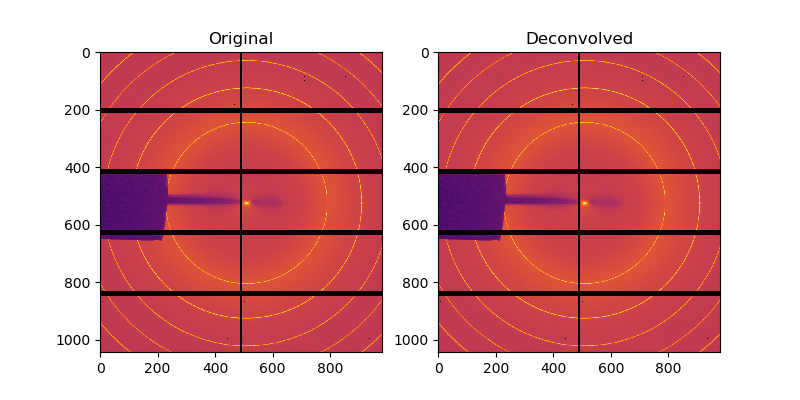

interactive(children=(FloatSlider(value=2.5, description='damp', max=5.0), Output()), _dom_classes=('widget-in…

In [8]:
img = images[0]
fl = img.astype("float32")
fl[msk] = 0.0 # set masked values to 0
blured = fl.ravel()
fig, ax = subplots(1, 2, figsize=(8,4))
im0 = ax[0].imshow(numpy.arcsinh(fl), cmap="inferno")
im1 = ax[1].imshow(numpy.arcsinh(fl), cmap="inferno")
ax[0].set_title("Original")
ax[1].set_title("Deconvolved")
def deconvol(damp):
    res = linalg.lsmr(csr.T, blured, damp=damp, x0=blured)
    restored = res[0].reshape(mask.shape)
    im1.set_data(numpy.arcsinh(restored))
    print("Number of negative pixels: %i"%(restored<0).sum())


interactive_plot = widgets.interactive(deconvol, damp=(0, 5.0))
display(interactive_plot)

In [9]:
#selection of the damping factor which provides no negative signal:
tot_neg = 100
damp = 0
while tot_neg>0:
    damp += 0.1
    tot_neg = 0
    deconvoluted = []
    for i, img in enumerate(images):
        fl = img.astype("float32")
        fl[msk] = 0.0 # set masked values to 0
        bl = fl.ravel()
        res = linalg.lsmr(csr.T, bl, damp=damp)
        neg=(res[0]<0).sum()
        print(i, damp, neg, res[1:])
        tot_neg += neg
        deconvoluted.append(res[0].reshape(img.shape))
print("damp:",damp)

0 0.1 12872 (2, 19, 4321779.35150566, 5.803641113519436, 1.6995850617640857, 3.3582417538199376, 41659969.98554161)
1 0.1 12250 (2, 19, 3757169.8995306906, 6.135248689092134, 1.7032968276952476, 3.442943267728284, 36395286.6620507)
2 0.1 17393 (2, 20, 1577640.5341739412, 2.2241199080898126, 1.739217853033561, 3.485600761960406, 15078086.2824897)
0 0.2 11689 (2, 14, 7889540.65802813, 5.133807239271567, 1.466189729926675, 2.7024543620078028, 34991613.76254249)
1 0.2 10719 (2, 14, 6931105.172705148, 4.7182678428707705, 1.4712118254370397, 2.7256366365716107, 31156865.95377047)
2 0.2 14893 (2, 14, 2838307.0872005536, 2.7735637679209546, 1.4652046267714205, 2.7182425846299467, 12392344.981435211)
0 0.30000000000000004 9574 (2, 11, 10557039.34545076, 3.9912227744921145, 1.3062471672647964, 2.262955649019415, 28202640.945378628)
1 0.30000000000000004 9043 (2, 10, 9364905.024348436, 11.481832262884733, 1.2549590447570944, 2.2280699454584427, 25507023.638021868)
2 0.30000000000000004 12141 (2, 

0 2.3000000000000007 10 (2, 3, 18024520.020207558, 7.758250761973735, 0.7194136168242463, 1.0063364429756794, 1486974.3386557356)
1 2.3000000000000007 1 (2, 3, 16406807.808549903, 6.67033942360869, 0.730482580696584, 1.006831416828166, 1388760.8622023384)
2 2.3000000000000007 0 (2, 3, 6298451.789557654, 3.2963747648126747, 0.7118561646579522, 1.0065634412899156, 509552.5599771439)
0 2.400000000000001 10 (2, 3, 18051060.75511721, 6.0563896250851235, 0.7194136168242463, 1.005823504284504, 1370029.7119637202)
1 2.400000000000001 1 (2, 3, 16432242.42201949, 5.208350297807859, 0.730482580696584, 1.0062796810679773, 1279636.1575706126)
2 2.400000000000001 0 (2, 3, 6307370.514617308, 2.5728659518542454, 0.7118561646579522, 1.006030076182735, 469447.8437051946)
0 2.500000000000001 7 (2, 3, 18074590.18885645, 4.773156164533405, 0.7194136168242463, 1.0053702576762722, 1266211.3613354408)
1 2.500000000000001 1 (2, 3, 16454792.767768912, 4.1056565183932126, 0.730482580696584, 1.0057919708777772, 1

<IPython.core.display.Javascript object>


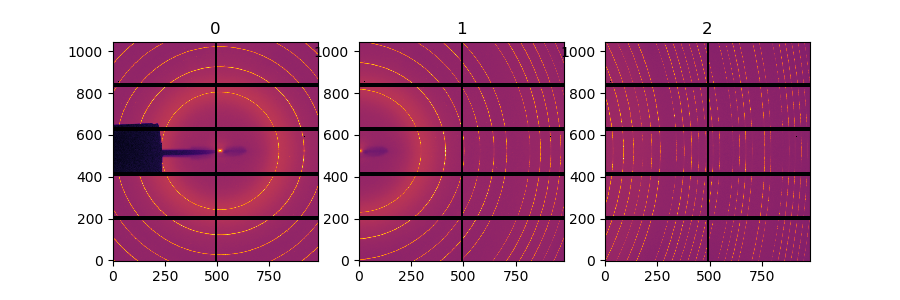

In [10]:
#Display deconvoluted images:
fig, ax = subplots(1, 3, figsize=(9,3))
for i,img in enumerate(deconvoluted):
    jupyter.display(img, ax=ax[i], label=str(i))

### Validation using the goniometer refinement 

At this point we are back to the initial state: can we fit the goniometer and check the width of the peaks to validate if it got better.

In [11]:
wavelength=0.6968e-10
calibrant = get_calibrant("LaB6")
calibrant.wavelength = wavelength
print(calibrant)

detector =  pyFAI.detector_factory("Pilatus1M")
detector.mask = mask

fimages = []
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[0], header={"angle":0}))
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[1], header={"angle":17}))
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[2], header={"angle":45}))

LaB6 Calibrant with 120 reflections at wavelength 6.968e-11


In [12]:
def get_angle(metadata):
    """Takes the basename (like det130_g45_0001.cbf ) and returns the angle of the detector"""
    return metadata["angle"]

In [13]:
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

In [14]:
gonioref2d = GoniometerRefinement.sload("id28.json", pos_function=get_angle)

In [15]:
for idx, fimg in enumerate(fimages):
    sg = gonioref2d.new_geometry(str(idx), image=fimg.data, metadata=fimg.header, calibrant=calibrant)
    print(sg.label, "Angle:", sg.get_position())

0 Angle: 0
1 Angle: 17
2 Angle: 45


<IPython.core.display.Javascript object>


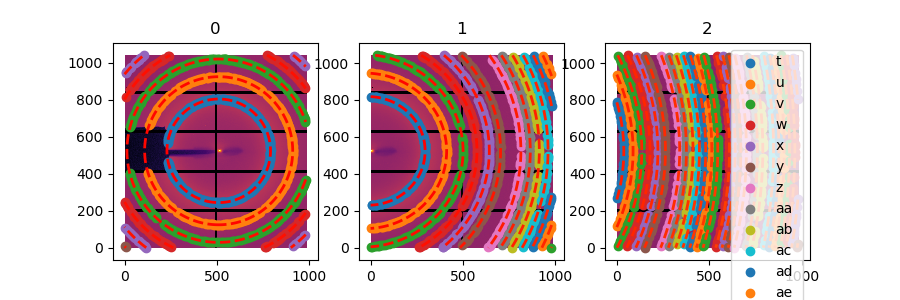

ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 6 groups of points:
# a ring 0: 348 points
# b ring 1: 341 points
# c ring 2: 316 points
# d ring 3: 129 points
# e ring 4: 48 points
# f ring 5: 2 points


ControlPoints instance containing 13 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 13 groups of points:
# g ring 0: 177 points
# h ring 1: 172 points
# i ring 2: 168 points
# j ring 3: 123 points
# k ring 4: 106 points
# l ring 5: 94 points
# m ring 6: 80 points
# n ring 7: 77 points
# o ring 8: 71 points
# p ring 9: 67 points
# q ring 10: 37 points
# r ring 11: 16 points
# s ring 12: 1 points


ControlPoints instance containing 26 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 26 groups of points:
# t ring 7: 37 points
# u ring 8: 54 points
# v ring 9: 66 points
# w ring 10: 64 points
# x ring 11: 62 points
# y ring 12: 61 points
# z ring 13: 57 points
#aa ring 14: 55 points
#ab ring 15: 55 points
#ac ring 16: 53 points
#ad ring 17: 53 points
#ae ring 18: 47 points
#af ring 19: 50 points
#ag ring 20: 49 points
#ah ring 21: 47 points
#ai ring 22: 47 points
#aj ring 23: 45 points
#ak ring 24: 45 points
#al ring 25: 43 points
#am ring 26: 43 points
#an ring 27: 42 points
#ao ring 28: 41 points
#ap ring 29: 41 points
#aq ring 30: 41 points
#ar ring 31: 19 points
#as ring 32: 2 points


In [16]:
# Display the control points freshly extracted on all 3 images:
fig,ax = subplots(1,3, figsize=(9,3))
for lbl, sg in gonioref2d.single_geometries.items():
    idx = int(lbl)
    print(sg.extract_cp())
    jupyter.display(sg=sg, ax=ax[idx])

In [17]:
#Refine the model:
gonioref2d.refine2()

Cost function before refinement: 3.3673221420529115e-08
[ 2.84547605e-01  8.86540301e-02  8.93070277e-02  5.48717450e-03
  5.54901577e-03  1.74619285e-02 -2.09889821e-05]
     fun: 2.0154279102942266e-08
     jac: array([-2.73861446e-07,  2.08617005e-07, -5.15585939e-07, -8.73413399e-08,
        2.27782748e-07, -1.43998916e-06, -1.32582441e-06])
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 2.84372950e-01,  8.86570506e-02,  8.93058252e-02,  5.48758195e-03,
        5.54888418e-03,  1.74617893e-02, -2.08430380e-05])
Cost function after refinement: 2.0154279102942266e-08
GonioParam(dist=0.28437295014349545, poni1=0.08865705061324418, poni2=0.08930582517579298, rot1=0.005487581950208836, rot2=0.005548884181614612, scale1=0.017461789295730078, scale2=-2.0843037974184558e-05)
maxdelta on: dist (0) 0.2845476046521533 --> 0.28437295014349545


array([ 2.84372950e-01,  8.86570506e-02,  8.93058252e-02,  5.48758195e-03,
        5.54888418e-03,  1.74617893e-02, -2.08430380e-05])

  File "/users/kieffer/.venv/py38/lib/python3.8/site-packages/pyFAI/multi_geometry.py", line 142, in integrate1d
    res = ai.integrate1d(data, npt=npt,


MultiGeometry integrator with 3 geometries on (0, 63) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


<IPython.core.display.Javascript object>


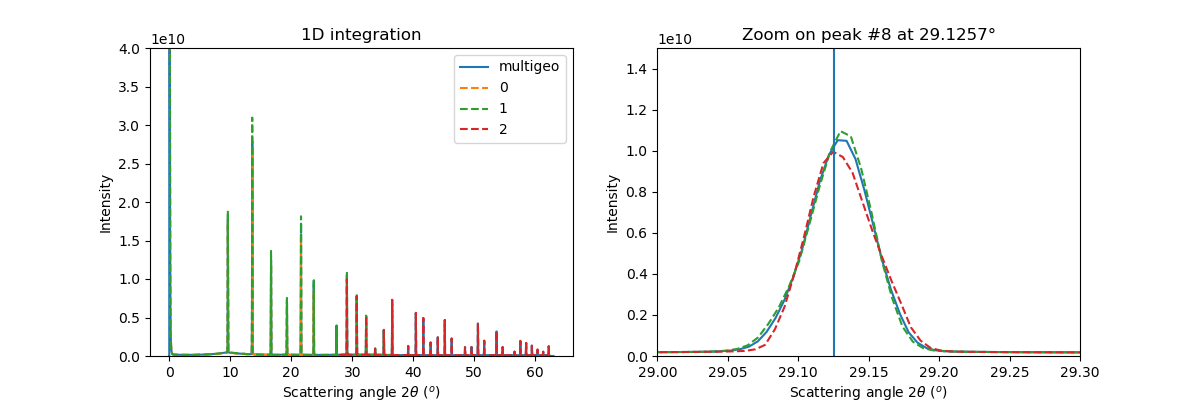

  File "<ipython-input-18-6986d308b140>", line 24, in <module>
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")


In [18]:
# Create a MultiGeometry integrator from the refined geometry:


angles = []
dimages = []
for sg in gonioref2d.single_geometries.values():
    angles.append(sg.get_position())
    dimages.append(sg.image)

multigeo = gonioref2d.get_mg(angles)
multigeo.radial_range=(0, 63)
print(multigeo)
# Integrate the whole set of images in a single run:

res_mg = multigeo.integrate1d(dimages, 10000)
fig, ax = subplots(1, 2, figsize=(12,4))
ax0 = jupyter.plot1d(res_mg, label="multigeo", ax=ax[0])
ax1 = jupyter.plot1d(res_mg, label="multigeo", ax=ax[1])

# Let's focus on the inner most ring on the image taken at 45°:
for lbl, sg in gonioref2d.single_geometries.items():
    ai = gonioref2d.get_ai(sg.get_position())
    img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
    ax0.plot(*res, "--", label=lbl)
    ax1.plot(*res, "--", label=lbl)
ax1.set_xlim(29,29.3)
ax0.set_ylim(0, 4e10)
ax1.set_ylim(0, 1.5e10)
p8tth = numpy.rad2deg(calibrant.get_2th()[7])
ax1.set_title("Zoom on peak #8 at %.4f°"%p8tth)
l = Line2D([p8tth, p8tth], [0, 2e10])
ax1.add_line(l)
ax0.legend()
ax1.legend().remove()

<IPython.core.display.Javascript object>


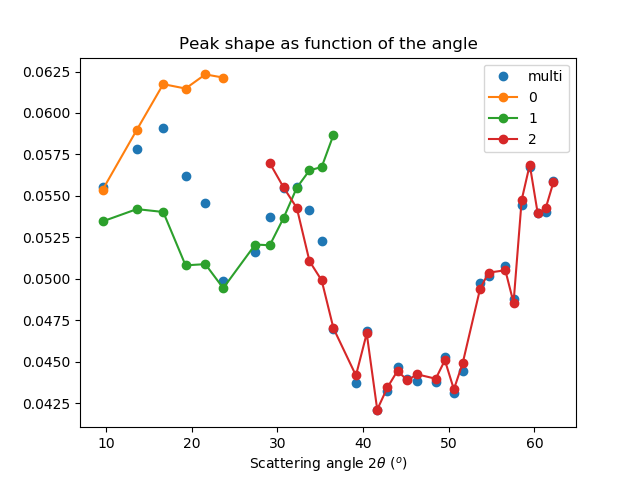

  File "<ipython-input-19-dc6d9f0ee241>", line 51, in <module>
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")


In [19]:
#Peak FWHM

from scipy.interpolate import interp1d
from scipy.optimize import bisect

def calc_fwhm(integrate_result, calibrant):
    "calculate the tth position and FWHM for each peak"
    delta = integrate_result.intensity[1:] - integrate_result.intensity[:-1]
    maxima = numpy.where(numpy.logical_and(delta[:-1]>0, delta[1:]<0))[0]
    minima = numpy.where(numpy.logical_and(delta[:-1]<0, delta[1:]>0))[0]
    maxima += 1
    minima += 1
    tth = []
    FWHM = []
    for tth_rad in calibrant.get_2th():
        tth_deg = tth_rad*integrate_result.unit.scale
        if (tth_deg<=integrate_result.radial[0]) or (tth_deg>=integrate_result.radial[-1]):
            continue
        idx_theo = abs(integrate_result.radial-tth_deg).argmin()
        id0_max = abs(maxima-idx_theo).argmin()
        id0_min = abs(minima-idx_theo).argmin()
        I_max = integrate_result.intensity[maxima[id0_max]]
        I_min = integrate_result.intensity[minima[id0_min]]
        tth_maxi = integrate_result.radial[maxima[id0_max]]
        I_thres = (I_max + I_min)/2.0
        if minima[id0_min]>maxima[id0_max]:
            if id0_min == 0:
                min_lo = integrate_result.radial[0]
            else:
                min_lo = integrate_result.radial[minima[id0_min-1]]
            min_hi = integrate_result.radial[minima[id0_min]]
        else:
            if id0_min == len(minima) -1:
                min_hi = integrate_result.radial[-1]
            else:
                min_hi = integrate_result.radial[minima[id0_min+1]]
            min_lo = integrate_result.radial[minima[id0_min]]
            
        f = interp1d(integrate_result.radial, integrate_result.intensity-I_thres)
        tth_lo = bisect(f, min_lo, tth_maxi)
        tth_hi = bisect(f, tth_maxi, min_hi)
        FWHM.append(tth_hi-tth_lo)
        tth.append(tth_deg)
    return tth, FWHM
    
fig, ax = subplots()
ax.plot(*calc_fwhm(res_mg, calibrant), "o", label="multi")
for lbl, sg in gonioref2d.single_geometries.items():
    ai = gonioref2d.get_ai(sg.get_position())
    img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
    t,w = calc_fwhm(res, calibrant=calibrant)
    ax.plot(t, w,"-o", label=lbl)
ax.set_title("Peak shape as function of the angle")
ax.set_xlabel(res_mg.unit.label)
ax.legend()


### Conclusion on deconvolution using least-squares:

The results do not look enhanced compared to the initial fit: neither the peak position, nor the FWHM looks enhanced. Maybe there is an error somewhere.

## Pseudo inverse with positivitiy constrain and poissonian noise (MLEM)

MLEM has provided similar results to least-sqares pseudo inversion with positivity constrains and the assumption of poisson noise.

In [20]:
# Function used for ONE MLEM iteration:

def iterMLEM_scipy(F, M, R):
    "Perform one iteration"
    #res = F * (R.T.dot(M))/R.dot(F)# / M.sum(axis=-1)
    norm = 1/R.T.dot(numpy.ones_like(F)) 
    cor = R.T.dot(M/R.dot(F))
    #print(norm.shape, F.shape, cor.shape)
    res = norm * F * cor
    res[numpy.isnan(res)] = 1.0
    return res

In [21]:
def deconv_MLEM(csr, data, thres=0.2, maxiter=1e6):
    R = csr.T
    msk = data<0
    img = data.astype("float32")
    img[msk] = 0.0 # set masked values to 0, negative values could induce errors
    M = img.ravel()
    #F0 = numpy.random.random(data.size)#M#
    F0 = R.T.dot(M)
    F1 = iterMLEM_scipy(F0, M, R)
    delta = abs(F1-F0).max()
    for i in range(int(maxiter)):
        if delta<thres:
            break
        F2 = iterMLEM_scipy(F1, M, R)
        delta = abs(F1-F2).max()
        if i%100==0:
            print(i, delta)
        F1 = F2
        i+=1
    print(i, delta)
    return F2.reshape(img.shape)

<ipython-input-20-445809682616>:6: RuntimeWarning: divide by zero encountered in true_divide
  norm = 1/R.T.dot(numpy.ones_like(F))
<ipython-input-20-445809682616>:7: RuntimeWarning: invalid value encountered in true_divide
  cor = R.T.dot(M/R.dot(F))
<ipython-input-20-445809682616>:9: RuntimeWarning: invalid value encountered in multiply
  res = norm * F * cor


0 261749.75
100 213.72461
200 33.487305
300 17.201172
400 7.6657715
500 4.576172
600 4.2441406
700 3.5986328
800 2.6015625
900 1.8101807
1000 1.6519775
1100 1.4206543
1200 1.1889648
1300 0.98583984
1400 0.8175049
1500 0.68078613
1600 0.5706177
1700 0.4817505
1800 0.4093628
1900 0.3505249
2000 0.3024292


<IPython.core.display.Javascript object>


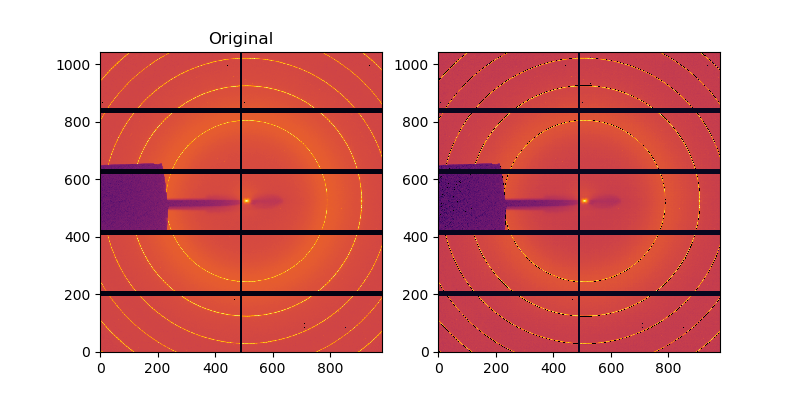

Text(0.5, 1.0, 'Original')

In [22]:
raw = images[0]
cor = deconv_MLEM(csr, images[0], maxiter=2000)

#Display one corrected image:
fig, ax = subplots(1, 2, figsize=(8,4))
im0 = ax[0].imshow(numpy.arcsinh(raw), origin="lower", cmap="inferno")
im1 = ax[1].imshow(numpy.arcsinh(cor), origin="lower", cmap="inferno")
ax[0].set_title("Original")


In [23]:
deconvoluted = []
for i, img in enumerate(images):
    cor = deconv_MLEM(csr, img, maxiter=2000)
    deconvoluted.append(cor)

0 261749.75


<ipython-input-20-445809682616>:6: RuntimeWarning: divide by zero encountered in true_divide
  norm = 1/R.T.dot(numpy.ones_like(F))
<ipython-input-20-445809682616>:7: RuntimeWarning: invalid value encountered in true_divide
  cor = R.T.dot(M/R.dot(F))
<ipython-input-20-445809682616>:9: RuntimeWarning: invalid value encountered in multiply
  res = norm * F * cor


100 213.72461
200 33.487305
300 17.201172
400 7.6657715
500 4.576172
600 4.2441406
700 3.5986328
800 2.6015625
900 1.8101807
1000 1.6519775
1100 1.4206543
1200 1.1889648
1300 0.98583984
1400 0.8175049
1500 0.68078613
1600 0.5706177
1700 0.4817505
1800 0.4093628
1900 0.3505249
2000 0.3024292
0 394156.12
100 159.75
200 53.876465
300 19.886719
400 9.824219
500 4.1445312
600 2.481018
700 1.7006226
800 1.2156067
900 0.89572144
1000 0.6750183
1100 0.5174103
1200 0.4018402
1300 0.31533813
1400 0.2565918
1500 0.25
1600 0.25
1700 0.25
1800 0.25
1900 0.25
2000 0.25
0 144116.5
100 69.64014
200 61.948242
300 19.260742
400 16.578613
500 16.04004
600 11.899902
700 8.777344
800 6.4873047
900 4.6914062
1000 3.3779297
1100 2.5742188
1200 2.043579
1300 1.654541
1400 1.3623047
1500 1.1380615
1600 0.9626465
1700 0.8230591
1800 0.71051025
1900 0.6185913
2000 0.54333496


In [24]:
# # Re-normalization
# for img, cor in zip(images, deconvoluted):
#     msk = img>=0
#     ratio = img[msk].sum()/cor[msk].sum()
#     print(ratio)
#     cor *= ratio
#     cor[numpy.logical_not(msk)] = -1

<IPython.core.display.Javascript object>


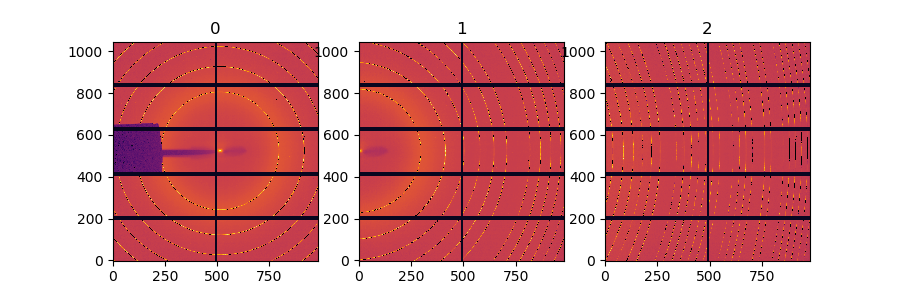

In [25]:
fig, ax = subplots(1, 3, figsize=(9,3))
for i,img in enumerate(deconvoluted):
    jupyter.display(img, ax=ax[i], label=str(i))

In [26]:
wavelength=0.6968e-10
calibrant = get_calibrant("LaB6")
calibrant.wavelength = wavelength
print(calibrant)

detector =  pyFAI.detector_factory("Pilatus1M")
detector.mask = mask

fimages = []
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[0], header={"angle":0}))
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[1], header={"angle":17}))
fimages.append(fabio.cbfimage.CbfImage(data=deconvoluted[2], header={"angle":45}))

LaB6 Calibrant with 120 reflections at wavelength 6.968e-11


In [27]:
def get_angle(metadata):
    """Takes the basename (like det130_g45_0001.cbf ) and returns the angle of the detector"""
    return metadata["angle"]

In [28]:
gonioref2d = GoniometerRefinement.sload("id28.json", pos_function=get_angle)

In [29]:
for idx, fimg in enumerate(fimages):
    sg = gonioref2d.new_geometry(str(idx), image=fimg.data, metadata=fimg.header, calibrant=calibrant)
    print(sg.label, "Angle:", sg.get_position())

0 Angle: 0
1 Angle: 17
2 Angle: 45


<IPython.core.display.Javascript object>


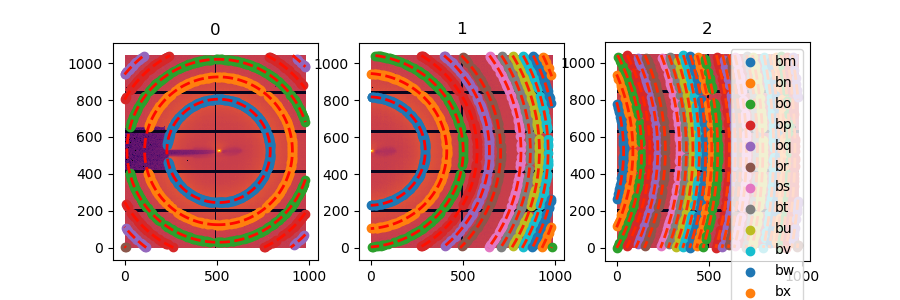

ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 6 groups of points:
#at ring 0: 348 points
#au ring 1: 341 points
#av ring 2: 316 points
#aw ring 3: 129 points
#ax ring 4: 48 points
#ay ring 5: 2 points


ControlPoints instance containing 13 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 13 groups of points:
#az ring 0: 177 points
#ba ring 1: 172 points
#bb ring 2: 168 points
#bc ring 3: 123 points
#bd ring 4: 106 points
#be ring 5: 94 points
#bf ring 6: 80 points
#bg ring 7: 77 points
#bh ring 8: 71 points
#bi ring 9: 67 points
#bj ring 10: 37 points
#bk ring 11: 16 points
#bl ring 12: 1 points


ControlPoints instance containing 26 group of point:
LaB6 Calibrant with 120 reflections at wavelength 6.968e-11
Containing 26 groups of points:
#bm ring 7: 37 points
#bn ring 8: 54 points
#bo ring 9: 66 points
#bp ring 10: 64 points
#bq ring 11: 62 points
#br ring 12: 61 points
#bs ring 13: 57 points
#bt ring 14: 55 points
#bu ring 15: 55 points
#bv ring 16: 53 points
#bw ring 17: 53 points
#bx ring 18: 47 points
#by ring 19: 50 points
#bz ring 20: 49 points
#ca ring 21: 47 points
#cb ring 22: 47 points
#cc ring 23: 45 points
#cd ring 24: 45 points
#ce ring 25: 43 points
#cf ring 26: 43 points
#cg ring 27: 42 points
#ch ring 28: 41 points
#ci ring 29: 41 points
#cj ring 30: 41 points
#ck ring 31: 19 points
#cl ring 32: 3 points


In [30]:
# Display the control points freshly extracted on all 3 images:

fig,ax = subplots(1,3, figsize=(9,3))
for lbl, sg in gonioref2d.single_geometries.items():
    idx = int(lbl)
    print(sg.extract_cp())
    jupyter.display(sg=sg, ax=ax[idx])

In [31]:
gonioref2d.refine2()

Cost function before refinement: 3.037350271380645e-08
[ 2.84547605e-01  8.86540301e-02  8.93070277e-02  5.48717450e-03
  5.54901577e-03  1.74619285e-02 -2.09889821e-05]
     fun: 2.120955314965296e-08
     jac: array([ 1.29654915e-07,  1.01045028e-07,  2.88223149e-06, -7.07675797e-07,
        4.29006277e-08, -2.74859755e-05, -7.14978527e-08])
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 2.84404213e-01,  8.86563321e-02,  8.93061609e-02,  5.48644529e-03,
        5.54944418e-03,  1.74618742e-02, -2.05693817e-05])
Cost function after refinement: 2.120955314965296e-08
GonioParam(dist=0.2844042128582021, poni1=0.08865633212302218, poni2=0.08930616086606516, rot1=0.005486445293758012, rot2=0.005549444178278475, scale1=0.017461874170621113, scale2=-2.056938172161214e-05)
maxdelta on: dist (0) 0.2845476046521533 --> 0.2844042128582021


array([ 2.84404213e-01,  8.86563321e-02,  8.93061609e-02,  5.48644529e-03,
        5.54944418e-03,  1.74618742e-02, -2.05693817e-05])

MultiGeometry integrator with 3 geometries on (0, 63) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


<IPython.core.display.Javascript object>


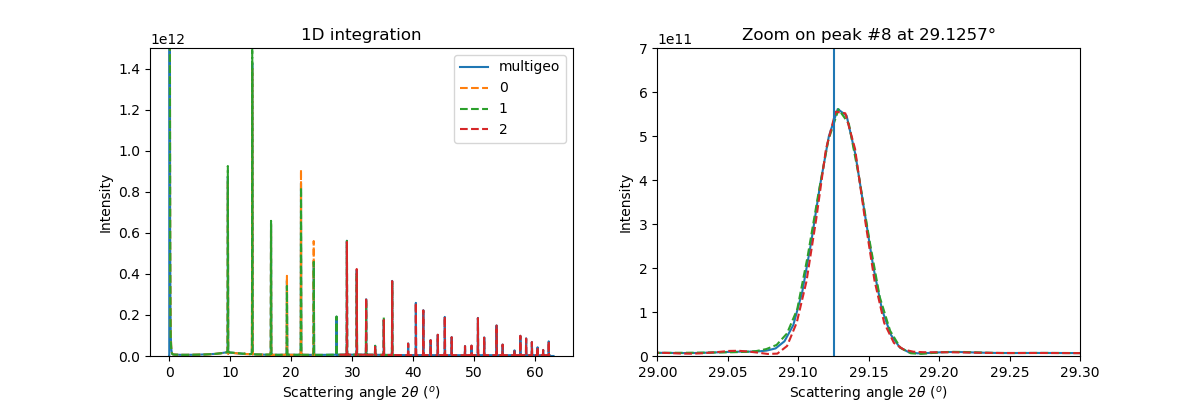

  File "<ipython-input-32-93245475420e>", line 23, in <module>
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")


In [32]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
dimages = []
for sg in gonioref2d.single_geometries.values():
    angles.append(sg.get_position())
    dimages.append(sg.image)

multigeo = gonioref2d.get_mg(angles)
multigeo.radial_range=(0, 63)
print(multigeo)
# Integrate the whole set of images in a single run:

res_mg = multigeo.integrate1d(dimages, 10000)
fig, ax = subplots(1, 2, figsize=(12,4))
ax0 = jupyter.plot1d(res_mg, label="multigeo", ax=ax[0])
ax1 = jupyter.plot1d(res_mg, label="multigeo", ax=ax[1])

# Let's focus on the inner most ring on the image taken at 45°:
for lbl, sg in gonioref2d.single_geometries.items():
    ai = gonioref2d.get_ai(sg.get_position())
    img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
    ax0.plot(*res, "--", label=lbl)
    ax1.plot(*res, "--", label=lbl)
ax1.set_xlim(29,29.3)
ax0.set_ylim(0, 1.5e12)
ax1.set_ylim(0, 7e11)
p8tth = numpy.rad2deg(calibrant.get_2th()[7])
ax1.set_title("Zoom on peak #8 at %.4f°"%p8tth)
l = Line2D([p8tth, p8tth], [0, 2e12])
ax1.add_line(l)
ax0.legend()
ax1.legend().remove()

<IPython.core.display.Javascript object>


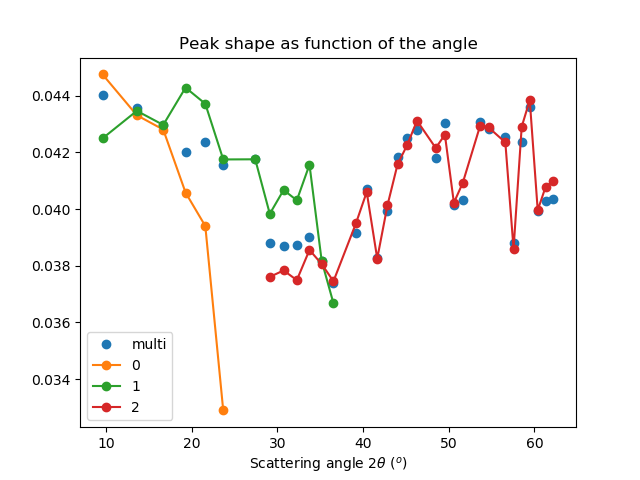

  File "<ipython-input-33-6b18d6c981da>", line 7, in <module>
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")


In [33]:
# FWHM plot
fig, ax = subplots()
ax.plot(*calc_fwhm(res_mg, calibrant), "o", label="multi")
for lbl, sg in gonioref2d.single_geometries.items():
    ai = gonioref2d.get_ai(sg.get_position())
    img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
    t,w = calc_fwhm(res, calibrant=calibrant)
    ax.plot(t, w,"-o", label=lbl)
ax.set_title("Peak shape as function of the angle")
ax.set_xlabel(res_mg.unit.label)
ax.legend()

## Conclusion

The MLEM deconvolution provided thinner peak (~10% thinner), the fit for the geometry is in the same level of quality. 
Deconvoluted images are more noisy and there is a ring with zeros shadowing close to the highest intensities.


For the future (i.e. TODO):
* Properly treat masked pixel as invalid ones
* Provide some regulatization to induce less moise.
* Implement MLEM in a more efficient way (cython, OpenCL, ...)

In [34]:
print(f"Total execution time: {time.time()-start_time} s")

Total execution time: 186.50916409492493 s
